In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Relative location of drive to DIP project folder
drive_loc='/content/gdrive/My Drive/DIP/'

In [0]:
import numpy as np
import cv2
import keras
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Sequential
from keras.models import Model,load_model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import random as rand

In [0]:
# Load MNIST dataset
(x_train,y_train), (x_test,y_test) = mnist.load_data()

In [0]:
img_rows, img_cols = 28, 28

# To handle generic images RGB or grey-scale
if K.image_data_format() == 'channels_first':
    # Case of RGB
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
  # Case of Grey-scale
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [16]:
# Normalizing the input

# Changing type to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Divide by 255 to normalize
x_train /= 255
x_test /= 255


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples


In [0]:
n_factor = 0.5

# Generate vector from Gaussain distribution 
Random_Noise = np.random.normal(loc=0.0,scale=1.0,size=x_train.shape)
x_train_n = x_train + n_factor*Random_Noise

Random_Noise = np.random.normal(loc=0.0,scale=1.0,size=x_test.shape)
x_test_n = x_test + n_factor*Random_Noise

# To keep them between 0 and 1
x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)

In [18]:
# Creating directories
!rm -r noise_data
!mkdir noise_data
!mkdir noise_data/original
!mkdir noise_data/noisy

# Writing original and noisy images for visuzlization

for i in range(50):
  A = x_train_n[i,:,:,:]*255
  A = A.astype('int')
  cv2.imwrite('noise_data/noisy/' + str(i) + '.png',A)
  
  A = x_train[i,:,:,:]*255
  A = A.astype('int')
  cv2.imwrite('noise_data/original/' + str(i) + '.png',A)
  
import shutil
shutil.make_archive('noise_data','zip','noise_data')

'/content/noise_data.zip'

In [19]:
# Encoder
model = Sequential()
model.add(Conv2D(16,(3, 3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(8, (3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(8,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),padding='same',name='encoder'))
# Encoded information size: (4,4,8)

# Decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
# Decoded information size: (28,28,1)

# Compile model
model.compile(optimizer='adadelta', loss='binary_crossentropy')

# Model Summary
print(model.summary())

from keras.utils import plot_model
plot_model(model,to_file='model.png')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0         
_________________________________________________________________
conv

In [0]:
epochs = 20
batch_size = 128

In [21]:
hist = model.fit(x_train_n,x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(x_test_n,x_test))
model.save(drive_loc + 'model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 133us/step - loss: 0.2439 - val_loss: 0.2002
Epoch 2/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.1847 - val_loss: 0.1767
Epoch 3/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.1680 - val_loss: 0.1575
Epoch 4/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.1585 - val_loss: 0.1529
Epoch 5/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.1528 - val_loss: 0.1488
Epoch 6/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.1492 - val_loss: 0.1473
Epoch 7/20
60000/60000 [==============================] - 4s 59us/step - loss: 0.1460 - val_loss: 0.1407
Epoch 8/20
60000/60000 [==============================] - 3s 58us/step - loss: 0.1440 - val_loss: 0.1405
Epoch 9/20
60000/60000 [==============================] - 4s 

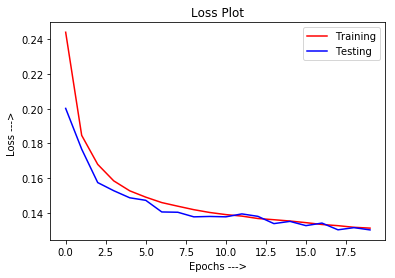

In [22]:
Training_Loss = hist.history['loss']
Validation_Loss = hist.history['val_loss']

plt.plot(Training_Loss,'r',label='Training')
plt.plot(Validation_Loss,'b',label='Testing')
plt.title('Loss Plot')
plt.xlabel('Epochs --->')
plt.ylabel('Loss ---> ')
plt.legend()
plt.show()

hist

In [0]:
model = load_model(drive_loc + 'model.h5')

In [0]:
!rm -r model_noise_data
!mkdir model_noise_data
!mkdir model_noise_data/input
!mkdir model_noise_data/output

for i in range(50):
  j = rand.randint(0,len(x_test_n))
  A = np.zeros((1,28,28,1))
  A[0,:,:,:] = x_test_n[i,:,:,:]
  B = model.predict(A)
  B = B.reshape((28,28,1))
  
  A = x_test_n[i,:,:,:]*255
  A = A.astype('int')
  cv2.imwrite('model_noise_data/input/' + str(i) + '.png',A)
  
  B = B*255
  B = B.astype('int')
  cv2.imwrite('model_noise_data/output/' + str(i) + '.png',B)
  
import shutil
shutil.make_archive('model_noise_data','zip','model_noise_data')